<a href="https://colab.research.google.com/github/PietroSchgor/Bayesian-Project/blob/main/Model2_GP_BETA_8_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Bayesian POLIMI

Mounted at /gdrive
/gdrive/My Drive/Bayesian POLIMI


In [1]:
# Install cmdstanpy module
!pip install cmdstanpy

!pip list | grep cmdstanpy


cmdstanpy                          1.2.5


In [2]:
# Install arviz module (With version 2.33.1 you will need a special version of arviz)
!pip install arviz
!pip list | grep arviz

arviz                              0.20.0


In [3]:
# Install cmdstan -- Just for the first time!
from cmdstanpy import install_cmdstan
install_cmdstan()

CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.36.0
Download successful, file: /tmp/tmpqv1tfz0a
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.36.0
Building version cmdstan-2.36.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.36.0
Test model compilation


True

In [4]:
from cmdstanpy import cmdstan_path
cmdstan_path()

'/root/.cmdstan/cmdstan-2.36.0'

In [5]:
# Create folder to store .stan files
import os
if not os.path.exists("./stan"):
    os.mkdir("./stan")

# Import modules
import numpy as np
import arviz as az
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Import functions
from cmdstanpy import CmdStanModel
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

# Upload data




In [6]:
y = pd.read_csv('TremorProb_1.csv')
print(y.head())

   -0.620922462937449  -0.668689165888089  -0.409872821087173  \
0           -0.620922           -0.668689           -0.409873   
1           -0.620922           -0.668689           -0.409873   
2           -0.620922           -0.668689           -0.409873   
3           -0.620922           -0.668689           -0.409873   
4           -0.620922           -0.668689           -0.409873   

   -0.46836544467914  -0.672098617117627  -0.568842619576277  \
0          -0.468365           -0.672099           -0.568843   
1          -0.468365           -0.672099           -0.568843   
2          -0.468365           -0.672099           -0.568843   
3          -0.468365           -0.672099           -0.568843   
4          -0.468365           -0.672099           -0.568843   

   -0.478079682575386  -0.417804016451204  -0.758451513461839  \
0            -0.47808           -0.417804           -0.758452   
1            -0.47808           -0.417804           -0.758452   
2            -0.47808        

In [7]:
N = y.shape[0]
d = y.shape[1]
print("Dimension is", N)
print("Sample is", d)

Dimension is 287
Sample is 15


In [8]:
x = np.linspace(0,1,N)

In [9]:
y = np.array(np.transpose(y))

In [10]:
y

array([[-0.62092246, -0.62092246, -0.62092246, ..., -0.62092246,
        -0.62092246, -0.62092246],
       [-0.66868917, -0.66868917, -0.66868917, ...,  0.59905107,
         0.25255206,  0.12731979],
       [-0.40987282, -0.40987282, -0.40987282, ..., -0.31308653,
        -0.35717438, -0.40126223],
       ...,
       [-0.4982822 , -0.4982822 , -0.4982822 , ..., -0.4982822 ,
        -0.4982822 , -0.4982822 ],
       [-0.6061394 , -0.6061394 , -0.6061394 , ..., -0.3327095 ,
        -0.43775713, -0.59682581],
       [-0.42226794, -0.42226794, -0.42226794, ..., -0.42226794,
        -0.42226794, -0.42226794]])

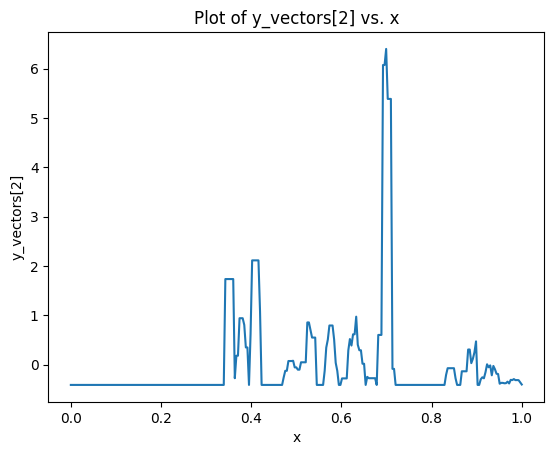

In [11]:
plt.plot(x, y[2,:])
plt.xlabel("x")
plt.ylabel("y_vectors[2]")
plt.title("Plot of y_vectors[2] vs. x")
plt.show()

# Current Model
This is the model we are going to use
$$
  y_t(s) = (1-\beta) \mu(s) + \beta y_{t-1}(s) + ϵ
$$

\\
Let $\mathbf{y}_{t}(s) = (Y(\mathbf{s}, t), \dots, Y(\mathbf{s}, t)) \in \mathbb{R}^{N}$. The hierarchical bayesian model is as follows

\\

\begin{aligned}
    \mathbf{y_t} \mid \beta, \mathbf{\mu}, \boldsymbol{\tau^2}, \mathbf{y_{t-1}} &\sim \text{multivariate normal}((1-\beta) \mu + \beta \mathbf{y}_{t-1}, diag(\tau^2))\\
    \mu &\sim \text{multivariate normal}(0,\sigma_{\alpha}^2 \mathbf{A}(\rho))\\
    %\rho &\sim \text{InvGamma}(5, 5) \\
    \sigma_\alpha &\sim \text{InvGamma}(1, 2) \\
    %\alpha &\sim \text{normal}(0, 1) \\
    \tau &\sim \text{InvGamma}(1, 2) \\
    \beta &\sim \text{Beta}(8,2)
\end{aligned}

And $$K\left(x \mid \alpha, \rho, \sigma \right)_{i,j} = \alpha^2 \exp \left( -\frac{1}{2\rho^2} \sum_{d=1}^{D} \left(x_{i,d} - x_{j,d}\right)^2 \right) + \delta_{i,j} \sigma^2$$

In [12]:
# Useful functions for the spatio-temporal model
spt_tools = \
"""
// Computes Temporal covariance kernel
matrix cov_time(int T, real rho_t) {
    matrix[T,T] cov;
    for (i in 1:T) {
        for(j in i:T) {
            cov[i,j] = rho_t^abs(i-j);
            cov[j,i] = cov[i,j];
        }
    }
    return (1/(1-rho_t^2)) * cov;
}

// Computes kronecker product between vectors
vector kron_prod(vector A, vector B){
    int N = size(A);
    int P = size(B);
    vector[N*P] kron;
    for (i in 1:N) {
        kron[((i-1)*P+1):i*P] = A[i] * B;
    }
    return kron;
}
"""

# Write functions to file
stan_file = "stan/spt-tools.stan"
with open(stan_file, "w") as f:
    print(spt_tools, file=f)

In [13]:
synt4_fitGP_ML = """
        functions {
            #include "spt-tools.stan"
        }

        data {
          int<lower=1> d;
          int<lower=1> N;
          int<lower=1> x;     // number of time intervals
          array[d] vector[N] Y; // previous was: matrix[N,d] y;
          vector[N] y0;
          real<lower=0> rho;  // time innovation coefficient
        }

        transformed data {
          // Temporal covariance matrix
          matrix[N,N] Ht = cov_time(x, rho);

          // Autoreggresive vector
          array[d] vector[N] y_n_1;
          y_n_1[1] = y0;
          for (j in 2:d) {
            y_n_1[j] = Y[j - 1];
          }
        }

        parameters {
          real<lower=0> sigmat;
          vector<lower=0>[N] tau;
          real<lower=0> beta;
          vector[N] mu;

        }

        transformed parameters {
            // Mean vector
            //vector[N] media = (1-beta)*mu + beta*y_n_1;

            // Temporal Covariance Matrix
            matrix[N,N] Sigma_t = sigmat * sigmat * Ht;
            matrix[N,N] Lalpha = cholesky_decompose(Sigma_t);
        }

        model {
          // Likelihood
          for (i in 1:d) {
            vector[N] media = (1 - beta) * mu + beta * y_n_1[i];
            Y[i][1:N] ~ normal(media[1:N], tau[1:N]);
          }
          // in case previous don't work Y_vect[1:N*d] ~ normal(media[1:N*d], tau_kro[1:N*d]);

          //Priors
          mu ~ multi_normal_cholesky(rep_vector(0,N), Lalpha);
          sigmat ~ inv_gamma(2, 1);
          tau ~ inv_gamma(2, 1);
          beta ~ beta(8,2);
        }

"""
# Write model to file
stan_file = "./stan/synt5GP_fitML.stan"
with open(stan_file, "w") as f:
    print(synt4_fitGP_ML, file=f)

# Compile stan model
stan_model = CmdStanModel(stan_file=stan_file)

13:37:18 - cmdstanpy - INFO - compiling stan file /content/stan/synt5GP_fitML.stan to exe file /content/stan/synt5GP_fitML
INFO:cmdstanpy:compiling stan file /content/stan/synt5GP_fitML.stan to exe file /content/stan/synt5GP_fitML
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=synt5GP_fitML.stan STANCFLAGS+=--include-paths=/content/stan /content/stan/synt5GP_fitML
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=synt5GP_fitML.stan --include-paths=/content/stan --o=/content/stan/synt5GP_fitML.hpp /content/stan/synt5GP_fitML.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/st

In [14]:
y.shape

(15, 287)

In [15]:
y0 = y[0, :] + np.random.normal(0,0.1,N)

In [16]:
y0.shape

(287,)

In [17]:
# Prepare data list for stan
input_data = {
    "d": d,
    "N": N,
    "x": 287,
    "Y": y,
    "y0": y0,
    "rho": 0.3
}
#specify with the same names you put in data!

# Run the sampler
stan_fit = stan_model.sample(data=input_data, chains=4, parallel_chains=4,
                             iter_warmup=300, iter_sampling=1000)

# Convert chain to arviz format
cmdstanpy_data = az.from_cmdstanpy(stan_fit)

DEBUG:cmdstanpy:cmd: /content/stan/synt5GP_fitML info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxck5zlz2/7gx1g15p.json
13:39:06 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/synt5GP_fitML', 'id=1', 'random', 'seed=286', 'data', 'file=/tmp/tmpxck5zlz2/7gx1g15p.json', 'output', 'file=/tmp/tmpxck5zlz2/synt5GP_fitMLkespstke/synt5GP_fitML-20241219133906_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/synt5GP_fitML', 'id=3', 'random', 'seed=286', 'data', 'file=/tmp/tmpxck5zlz2/7gx1g15p.json', 'output', 'file=/tmp/tmpxck5zlz2/synt5GP_fitMLkespstke/synt5GP_fitML-20241219133906_3.csv', 'method=sample', 'num_samples=1000', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/synt5GP_fitML', 'id=2', 'random', 'seed=286', 'data', 'file=/tmp/tmpxck5

14:04:40 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/synt5GP_fitML', 'id=1', 'random', 'seed=286', 'data', 'file=/tmp/tmpxck5zlz2/7gx1g15p.json', 'output', 'file=/tmp/tmpxck5zlz2/synt5GP_fitMLkespstke/synt5GP_fitML-20241219133906_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=300', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpxck5zlz2/synt5GP_fitMLkespstke/synt5GP_fitML-20241219133906_1.csv
 console_msgs (if any):
	/tmp/tmpxck5zlz2/synt5GP_fitMLkespstke/synt5GP_fitML-20241219133906_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 300
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 (Default)


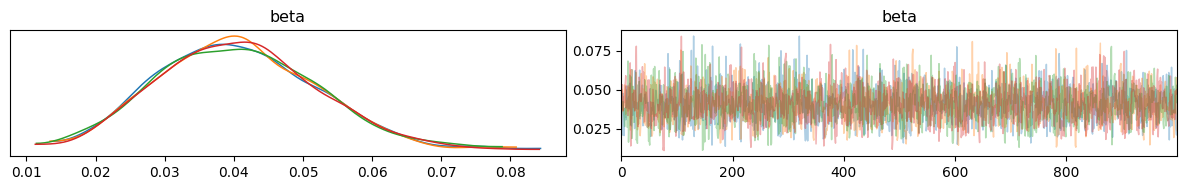

In [18]:
az.plot_trace(cmdstanpy_data['posterior']['beta'], compact=False)
plt.tight_layout()
plt.show()

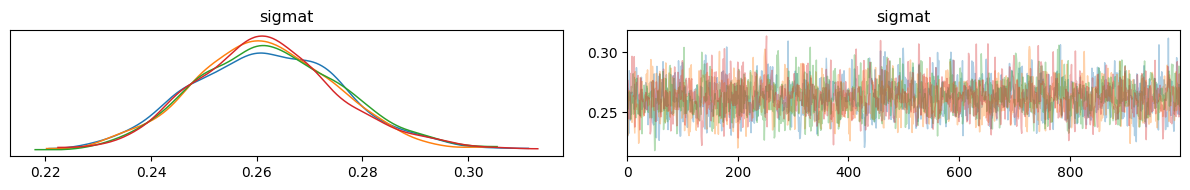

In [19]:
az.plot_trace(cmdstanpy_data['posterior']['sigmat'], compact=False)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (287), generating only 20 plots
  warnings.warn(


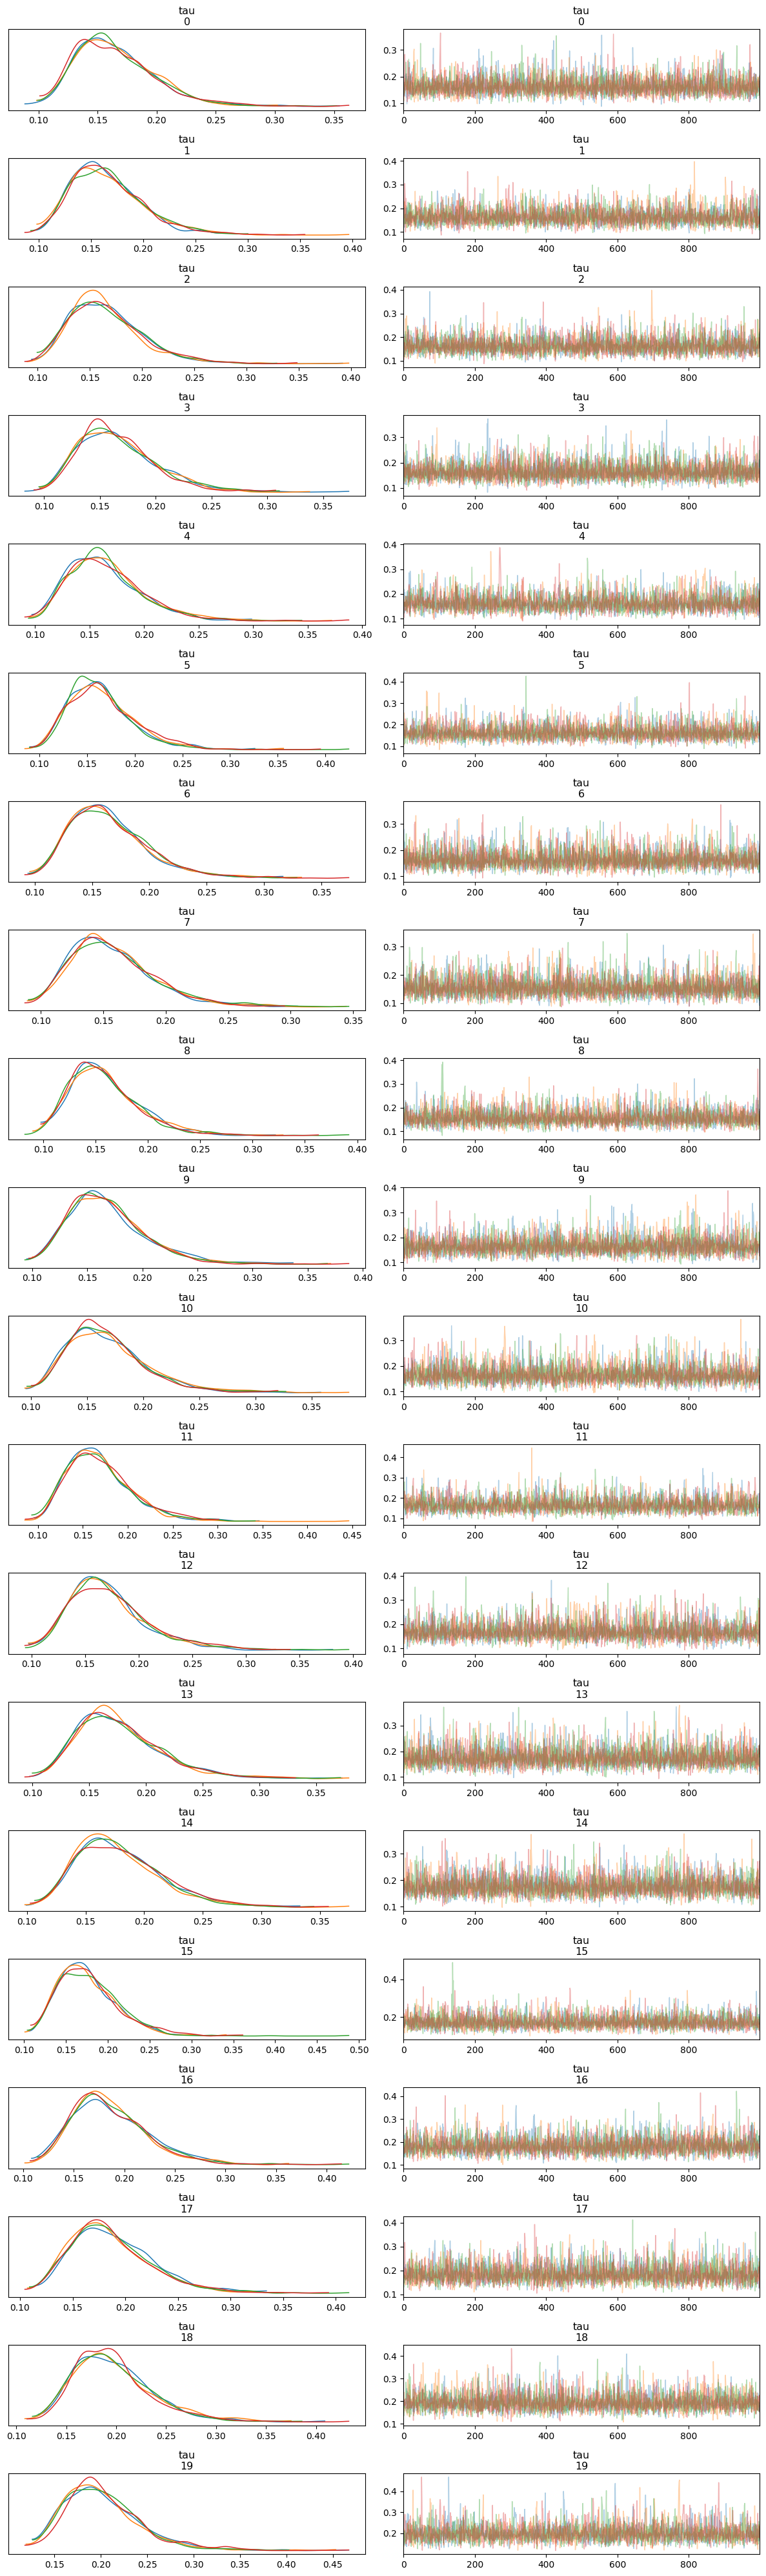

In [20]:
az.plot_trace(cmdstanpy_data['posterior']['tau'], compact=False)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (287), generating only 20 plots
  warnings.warn(


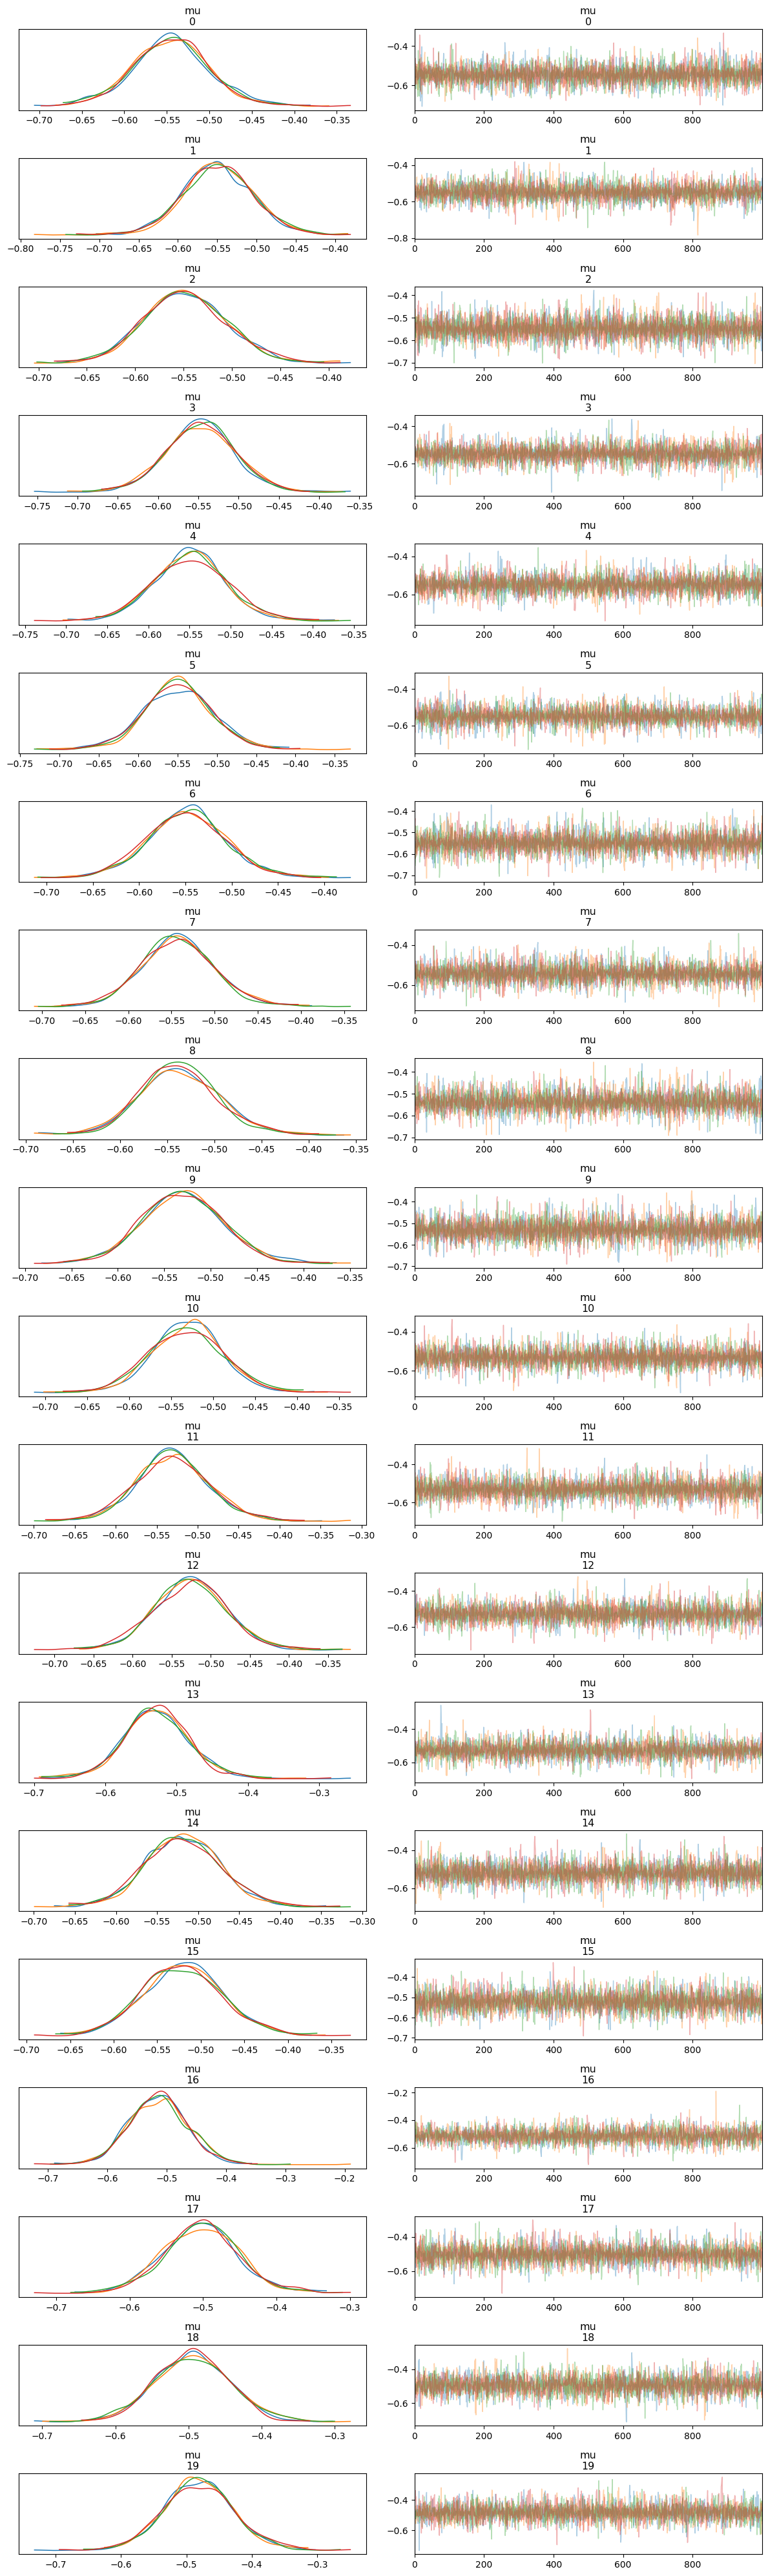

In [21]:
az.plot_trace(cmdstanpy_data['posterior']['mu'], compact=False)
plt.tight_layout()
plt.show()

In [22]:
betas = cmdstanpy_data['posterior']['beta'][3]
taus = cmdstanpy_data['posterior']['tau'][3]
mus = cmdstanpy_data['posterior']['mu'][3]
#sigmas = cmdstanpy_data['posterior']['sigma'][3]
beta = betas.mean().item() # convert to float
tau = taus.mean().item() # convert to float
mu = mus.mean().item() # convert to float
#sigma = sigmas.mean().item() # convert to float

In [23]:
mu = np.mean(mus, axis=0)

In [24]:
mu

<xarray.DataArray 'mu' (mu_dim_0: 287)> Size: 2kB
array([-0.54440316, -0.54992258, -0.54787337, -0.54707236, -0.5484909 ,
       -0.55007587, -0.55022796, -0.54307486, -0.53741599, -0.53120084,
       -0.53230289, -0.53165934, -0.52775927, -0.52812923, -0.51768793,
       -0.52143302, -0.51437902, -0.50062437, -0.49588796, -0.48001003,
       -0.47126468, -0.42257641, -0.39333056, -0.39769   , -0.40950453,
       -0.42434895, -0.44207581, -0.46673489, -0.46260666, -0.43344669,
       -0.42196301, -0.4206542 , -0.42514038, -0.43943648, -0.47398155,
       -0.49397836, -0.48734654, -0.47601   , -0.46990726, -0.48087777,
       -0.47787437, -0.48611428, -0.48229861, -0.49947284, -0.50334466,
       -0.49815205, -0.48425729, -0.47865174, -0.44291645, -0.42646414,
       -0.41675795, -0.42812927, -0.45225818, -0.44860417, -0.48147899,
       -0.41051072, -0.39552308, -0.39599014, -0.35008368, -0.34751253,
       -0.37770021, -0.46050487, -0.4858422 , -0.45046454, -0.48109618,
       -0.46515585, -0.34584341, -0.28048706, -0.2261178 , -0.20559723,
       -0.16831998, -0.16593136, -0.22960811, -0.22703961, -0.17333045,
       -0.18715699, -0.16872114, -0.12295011, -0.06175954, -0.02171667,
       -0.02006984, -0.01913365, -0.06718582, -0.19426768, -0.2834479 ,
       -0.30609707, -0.26631765, -0.20707448, -0.11890782, -0.05335131,
        0.00428561,  0.06306626,  0.08826722,  0.16155757,  0.18969456,
        0.20276993,  0.20730131,  0.24238996,  0.25690974,  0.20921988,
...
        0.02394053,  0.13710897,  0.20490939,  0.32487588,  0.37951618,
        0.4029663 ,  0.37723191,  0.34113464,  0.30900669,  0.26338027,
        0.237107  ,  0.22482722,  0.21452205,  0.19505423,  0.0864589 ,
        0.03030652,  0.00625367, -0.09305769, -0.2755446 , -0.09584724,
        0.00513334,  0.05358721,  0.06767188,  0.05708728,  0.12467122,
        0.08549788,  0.09450948,  0.09007883,  0.05452641,  0.16328438,
        0.20039089,  0.25832459,  0.25242842,  0.27345485,  0.27813089,
        0.22234453,  0.15418096,  0.06421486,  0.08841513,  0.10910179,
        0.20890707,  0.25825441,  0.26104376,  0.28897288,  0.32642426,
        0.3524547 ,  0.35915344,  0.35501663,  0.3405527 ,  0.31417242,
        0.17567303,  0.03429692, -0.03028068, -0.05856759,  0.04679001,
        0.0918834 ,  0.16209449,  0.19778841,  0.20759524,  0.19086665,
        0.12041752,  0.00782615, -0.02879235, -0.05106717, -0.1108609 ,
       -0.10585268, -0.06500653,  0.09016465,  0.1265361 ,  0.17748832,
        0.18125769,  0.16350078,  0.1441789 ,  0.03149262, -0.02344098,
       -0.13530036, -0.17557943, -0.28068594, -0.26183682, -0.22117492,
       -0.19515108, -0.1688441 , -0.22148811, -0.23860734, -0.23211787,
       -0.27534562, -0.30653362, -0.37133578, -0.33531286, -0.2936356 ,
       -0.24155311, -0.22898837, -0.23772712, -0.26792274, -0.30615368,
       -0.33546434, -0.4161482 ])
Coordinates:
    chain     int64 8B 3
  * mu_dim_0  (mu_dim_0) int64 2kB 0 1 2 3 4 5 6 ... 280 281 282 283 284 285 286

In [25]:
y_sim = beta*y[12,:] + (1-beta)*mu

In [26]:
tau = np.mean(taus, axis=0)
K = np.diag(tau)

In [27]:
y_draws = np.random.multivariate_normal(y_sim, K, 500)

In [28]:
y_new = np.mean(y_draws, axis=0)

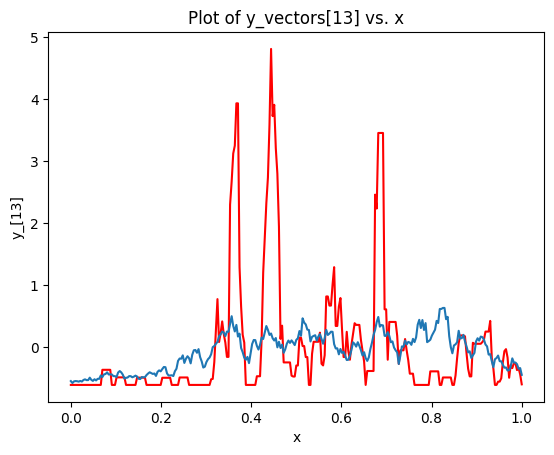

In [29]:
plt.plot(x, y[13,:], color="red")
plt.plot(x, y_new)
plt.xlabel("x")
plt.ylabel("y_[13]")
plt.title("Plot of y_vectors[13] vs. x")
plt.show()

Note: [extension to glm gaussian process](https://mc-stan.org/docs/stan-users-guide/gaussian-processes.html#discrete-outcomes-with-gaussian-processes) (not used in the project but interesting comunque)

Note for the future: [here to make predictions](https://mc-stan.org/docs/stan-users-guide/gaussian-processes.html#discrete-outcomes-with-gaussian-processes)